# Data preparation

### Now I would like to explore data using techniques shown in previous notebook

#### Today we will be trying to predict if total fare will be payed by cash or by credit card. I would like you now to do some data exploration. One sample new variable is shown below. At the end I would like you to save your data in new table.

In [1]:
spark

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [16]:
taxi = spark.sql("""
    SELECT
        taxi_id,
        trip_start_timestamp,
        trip_end_timestamp,
        trip_seconds,
        trip_miles,
        pickup_census_tract,
        dropoff_census_tract,
        pickup_community_area,
        dropoff_community_area,
        fare,
        tips,
        tolls,
        extras,
        trip_total,
        company,
        IF(payment_type='Credit Card',1,0) target
    FROM
        tomek.taxi_cleaned
    WHERE
        yyyymm BETWEEN 201601 AND 201612
""")

In [32]:
taxi.printSchema()

root
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: string (nullable = true)
 |-- trip_end_timestamp: string (nullable = true)
 |-- trip_seconds: long (nullable = true)
 |-- trip_miles: float (nullable = true)
 |-- pickup_census_tract: long (nullable = true)
 |-- dropoff_census_tract: long (nullable = true)
 |-- pickup_community_area: long (nullable = true)
 |-- dropoff_community_area: long (nullable = true)
 |-- fare: float (nullable = true)
 |-- tips: float (nullable = true)
 |-- tolls: float (nullable = true)
 |-- extras: float (nullable = true)
 |-- trip_total: float (nullable = true)
 |-- company: string (nullable = true)
 |-- target: integer (nullable = false)
 |-- tips_fare_ratio: double (nullable = true)
 |-- has_tips: boolean (nullable = true)



In [17]:
def extract_month(value):
    return value[5:7]

from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
udf_extract_month = udf(extract_month,StringType())

In [18]:
taxi\
    .withColumn("trip_month",udf_extract_month(taxi.trip_start_timestamp))\
    .groupBy("trip_month")\
    .avg("target").show()

+----------+-------------------+
|trip_month|        avg(target)|
+----------+-------------------+
|        07| 0.4454716431945906|
|        11|0.47340177433242253|
|        01|0.44041948161046435|
|        09| 0.4712843576033142|
|        05|0.46973558770749213|
|        08|0.45405980594931256|
|        03|0.46349716518143186|
|        02|0.45894048796506604|
|        06|0.47605840760571516|
|        10|0.47776483262245384|
|        12| 0.4381261736488949|
|        04|0.47348513794991554|
+----------+-------------------+



In [19]:
per_month_pd = taxi\
    .withColumn("trip_month",udf_extract_month(taxi.trip_start_timestamp))\
    .groupBy("trip_month")\
    .avg("target")\
    .toPandas()

In [20]:
per_month_pd.head()

,trip_month,avg(target)
0,07,0.445472
1,11,0.473402
2,01,0.440419
3,09,0.471284
4,05,0.469736


In [21]:
%matplotlib inline

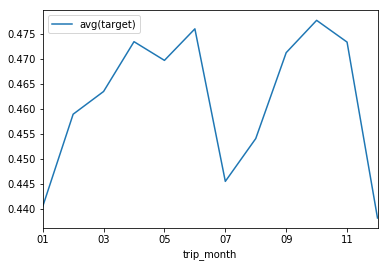

In [23]:
per_month_pd\
    .sort_values('trip_month')\
    .reset_index(drop=True)\
    .plot(x='trip_month',y='avg(target)')

### Please explore more potential variables using techniques shown in previous notebook.

Utwórz zmienne oparte o relacji między wartością napiwków a kwotą przejazdu. Utworzone zmienne będą zawierały informację o:

* stosunku między wartością napiwku a kwotą przejazdu,
* zero-jedynkową flagę odnoszącą się do tego, czy napiwek został zapłacony.

In [82]:
import pyspark.sql.functions as F

taxi = taxi.withColumn('tips_fare_ratio', F.col('tips') / F.col('fare'))
taxi = taxi.withColumn('has_tips', F.col('tips') > 0)
taxi.select(['tips_fare_ratio', 'has_tips']).show(10)

+-------------------+--------+
|    tips_fare_ratio|has_tips|
+-------------------+--------+
|                0.0|   false|
|                0.0|   false|
|                0.0|   false|
|0.20236686390532543|    true|
|0.25806451612903225|    true|
|                0.0|   false|
|0.17085271317829456|    true|
|0.20444444444444446|    true|
|                0.0|   false|
|                0.0|   false|
+-------------------+--------+
only showing top 10 rows



Zlicz liczbę wystąpień płatności danego typu w zależności od tego, czy został wypłacony napiwek.

In [83]:
taxi.groupBy(['target', 'has_tips'])\
    .count()\
    .show(10)

+------+--------+-------+
|target|has_tips|  count|
+------+--------+-------+
|     1|   false| 327029|
|     1|    true|6635148|
|     0|   false|8092729|
|     0|    true|   6989|
+------+--------+-------+



Następnie, skorzystamy z `QuantileDiscretizer` do utworzenia *binów* opartych na wartości zmiennej odnoszącej się do długości przejazdu (wyrażonej w milach).

In [84]:
from pyspark.ml.feature import QuantileDiscretizer

try:
    taxi = taxi.drop(F.col('trip_miles_bins'))
except:
    pass
qds = QuantileDiscretizer(
    numBuckets=5,
    inputCol='trip_miles',
    outputCol='trip_miles_bins'
)
trip_miles_qds = qds.fit(taxi)
# add column to taxi DataFrame
taxi = trip_miles_qds\
    .setHandleInvalid("skip")\
    .transform(taxi)

Wizualizuj zależność między *binem* a liczbą płatności danego typu.

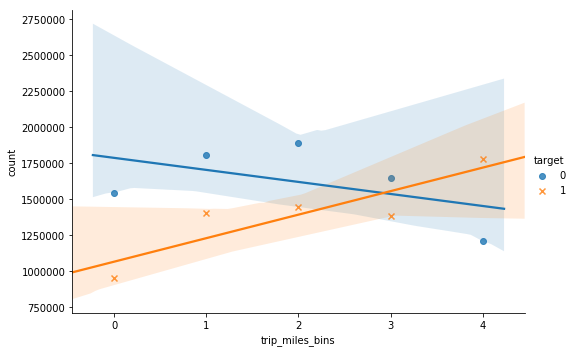

In [87]:
taxi_trip_miles_bins = taxi.groupBy(['target', 'trip_miles_bins'])\
    .count()\
    .sort(['target', 'trip_miles_bins'])\
    .toPandas()

sns.lmplot(
    x='trip_miles_bins',
    y='count',
    hue='target',
    markers=['o', 'x'],
    data=taxi_trip_miles_bins,
    aspect=12./8.
)

Następnie, sprawdź hipotezę, że taksówki, które jeżdżą rzadziej mogą bardziej preferować płatności gotówką; natomiast taksówki wykonujące wiele połączeń mogą stanowić firmy obsługujące korporacje.

In [94]:
import pyspark

def discretize_columns(
    df: pyspark.sql.dataframe.DataFrame,
    inputCol: str,
    outputCol: str,
    numBuckets: int = 10
) -> pyspark.sql.dataframe.DataFrame:
    """Discretize column and return DataFrame."""
    try:
        df = df.drop(F.col(outputCol))
    except:
        pass
    qds = QuantileDiscretizer(
        numBuckets=numBuckets,
        inputCol=inputCol,
        outputCol=outputCol
    )
    qds_fitted = qds.fit(df)
    # add column to taxi DataFrame
    return qds_fitted\
        .setHandleInvalid("skip")\
        .transform(df)

Wizualizuj zależnośc między wartością *bin* a liczbą płatności danego typu.

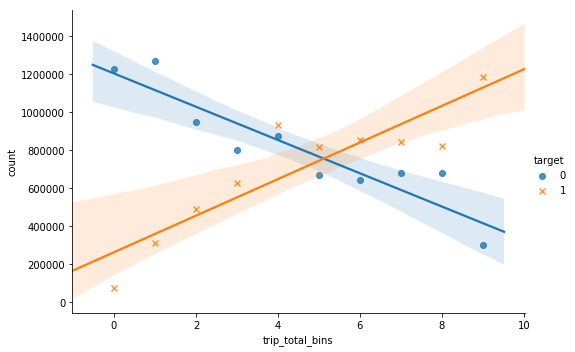

In [95]:
taxi = discretize_columns(taxi, 'trip_total', 'trip_total_bins')

taxi_trip_total_bins = taxi.groupBy(['target', 'trip_total_bins'])\
    .count()\
    .sort(['target', 'trip_total_bins'])\
    .toPandas()

sns.lmplot(
    x='trip_total_bins',
    y='count',
    hue='target',
    markers=['o', 'x'],
    data=taxi_trip_total_bins,
    aspect=12./8.
)

In [96]:
taxi.columns

['taxi_id',
 'trip_start_timestamp',
 'trip_end_timestamp',
 'trip_seconds',
 'trip_miles',
 'pickup_census_tract',
 'dropoff_census_tract',
 'pickup_community_area',
 'dropoff_community_area',
 'fare',
 'tips',
 'tolls',
 'extras',
 'trip_total',
 'company',
 'target',
 'tips_fare_ratio',
 'has_tips',
 'trip_miles_bins',
 'trip_total_bins']

In [110]:
taxi.withColumn(
    'same_community_area',
    F.col('pickup_community_area') == F.col('dropoff_community_area')
)\
    .select(['target', 'same_community_area'])\
    .groupBy(['target'])\
    .agg(F.avg(F.col('same_community_area').cast('integer')))\
    .show(50)

+------+-------------------------------------+
|target|avg(CAST(same_community_area AS INT))|
+------+-------------------------------------+
|     1|                  0.19101596831728584|
|     0|                   0.2758712773498324|
+------+-------------------------------------+



In [111]:
taxi = taxi.withColumn(
    'same_community_area',
    F.col('pickup_community_area') == F.col('dropoff_community_area')
)

### Write your final table

In [112]:
from uuid import uuid4

In [113]:
temp_name = str(uuid4())[:8]

In [114]:
taxi.createOrReplaceTempView(temp_name)

#### Please remember to replace n in table name with your number

In [115]:
spark.sql("""
    CREATE TABLE taxi.participant3 AS
    SELECT * FROM {temp_name}
""".format(temp_name=temp_name))

DataFrame[]